In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

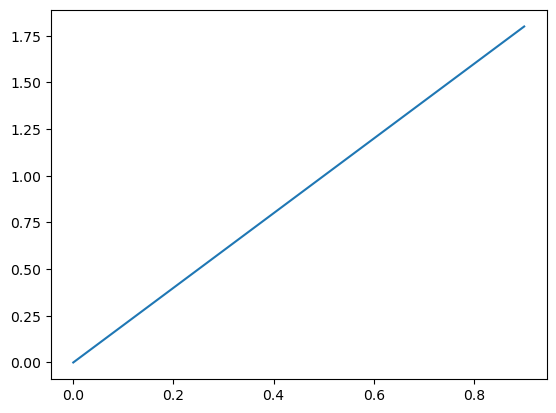

In [2]:
plt.plot(np.arange(0, 1, 0.1), 2*np.arange(0, 1, 0.1))

In [2]:
import h5py

In [3]:
from scipy.stats import norm

In [4]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
import scipy.io as sio
# import pandas as pd
import datetime
import os
# import readligo as rl
# from gwpy.timeseries import TimeSeries
import math
import random

import copy

In [5]:
import torch.nn.functional as F

In [16]:
os.chdir("D:\OneDrive - HKUST Connect\Research\GWNMMAD\Codes")

In [6]:
epochs_wsl = 100;

In [7]:
epochs = 100
rTrain = 0.7;
rTest = 0.2;
# input_vector_length = 100
batch_size = 32
num_bins = 40
coef_delta = 0

# 4-AE + WSL

## Networks

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(101, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 101),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [9]:
class WSClassifier(nn.Module):
    def __init__(self):
        super(WSClassifier, self).__init__()
        self.fc1 = nn.Linear(101, 32)  # 第一层全连接层，输入维度为4，输出维度为64
        self.norm1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 8)
        self.norm2 = nn.BatchNorm1d(8)
        self.fc4 = nn.Linear(8, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.norm1(self.relu(self.fc1(x)))
        x = self.norm2(self.relu(self.fc2(x)))
        return self.fc4(x)
        # x = self.relu(x)
#         x = self.sigmoid(x)

In [10]:
ae = AutoEncoder().cuda()
print(sum(p.numel() for p in ae.parameters() if p.requires_grad))

4161


In [11]:
wsc = WSClassifier().cuda()
print(sum(p.numel() for p in wsc.parameters() if p.requires_grad))

3617


## data loading

In [12]:
list_datatype = ["noise", "bbh", "sg", "glitch"]

In [13]:
N_wsl_total = 40000;
N_wsl = {}
N_wsl["noise"] = int(0.75*N_wsl_total)
N_wsl["bbh"] = int(0.1*N_wsl_total)
N_wsl["sg"] = int(0.1*N_wsl_total)
N_wsl["glitch"] = int(0.05*N_wsl_total)

In [18]:
dataset_raw = {};
dataset_raw["noise"] = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/background.npz")['data'][:, 0];
dataset_raw["bbh"] = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy")[:, 0];
dataset_raw["sg"] = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy")[:, 0];
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
dataset_raw["glitch"] = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"]

dataset_wsl = {};
dataset_ae = {};
dataset_wsl_fft = {};
dataset_ae_fft = {};

for dt in list_datatype:
    perm = np.random.permutation(len(dataset_raw[dt]))
    nwsl = N_wsl[dt]
    dataset_wsl[dt] = dataset_raw[dt][perm[:nwsl]]
    dataset_wsl[dt] = dataset_wsl[dt] / np.linalg.norm([dataset_wsl[dt]], axis=2).T
    dataset_wsl_fft[dt] = abs(np.fft.rfft(dataset_wsl[dt]))
    dataset_wsl_fft[dt] = dataset_wsl_fft[dt]/np.linalg.norm([dataset_wsl_fft[dt]], axis=2).T
    
    dataset_ae[dt]  = dataset_raw[dt][perm[nwsl:]]
    dataset_ae[dt] = dataset_ae[dt] / np.linalg.norm([dataset_ae[dt]], axis=2).T
    dataset_ae_fft[dt] = abs(np.fft.rfft(dataset_ae[dt]))
    dataset_ae_fft[dt] = dataset_ae_fft[dt]/np.linalg.norm([dataset_ae_fft[dt]], axis=2).T
    
    np.savetxt("../Data_cached/SequentialTraining/WSL/perm_"+dt+".dat", perm)

In [19]:
for key in dataset_ae_fft.keys():
    print(key)
    print(dataset_ae_fft[key].shape)

noise
(70000, 101)
bbh
(96000, 101)
sg
(96000, 101)
glitch
(58132, 101)


In [20]:
for key in dataset_wsl.keys():
    print(key)
    print(dataset_wsl[key].shape)

noise
(30000, 200)
bbh
(4000, 200)
sg
(4000, 200)
glitch
(2000, 200)


## training

In [21]:
version = "v1";

In [22]:
epochs = 50;

In [24]:
sequence = ["glitch", "noise", "bbh", "sg"];
ind2datatype = {};
datatype2ind = {};
for i, dt in enumerate(sequence):
    ind2datatype[i] = dt;
    datatype2ind[dt] = i;
    
torch.save(ind2datatype, "../Data_cached/SequentialTraining/WSL/sequence_"+version+".json")

In [25]:
dataset_wsl_fft_collected = np.empty((0, dataset_wsl_fft["glitch"].shape[1]))
for dt in sequence:
    dataset_wsl_fft_collected = np.vstack((dataset_wsl_fft_collected, dataset_wsl_fft[dt]))

In [87]:
# N_bkg = len(bkg_reserved_fft);
# N_glitch = int(N_bkg/15);
# N_bbh = int(N_bkg*2/15);
# N_sg = int(N_bkg*2/15);

# testset = np.empty((N_bkg+N_glitch+N_bbh+N_sg, len(bkg_reserved_fft[0])))

# s = 0;
# testset[s : s+N_glitch] = glitch_reserved_fft[np.random.permutation(len(glitch_reserved_fft))[:N_glitch]];
# s += N_glitch;

# testset[s : s+N_bkg] = bkg_reserved_fft[np.random.permutation(len(bkg_reserved_fft))[:N_bkg]];
# s += N_bkg;

# testset[s : s+N_bbh] = bbh_reserved_fft[np.random.permutation(len(bbh_reserved_fft))[:N_bbh]];
# s += N_bbh;

# testset[s : s+N_sg] = sg_reserved_fft[np.random.permutation(len(sg_reserved_fft))[:N_sg]];
# s += N_sg;

# correct_ans = np.concatenate(([0]*N_glitch, [1]*N_bkg, [2]*N_bbh, [3]*N_sg))

# Nsample = {};
# Nsample["glitch"] = N_glitch;
# Nsample["noise"] = N_bkg;
# Nsample["bbh"] = N_bbh;
# Nsample["sg"] = N_sg

In [27]:
Ncut = 5;
cutList = {};

max_glitch = 0.0026;
min_glitch = 0.001;
cutList["glitch"] = np.linspace(min_glitch, max_glitch, Ncut);

max_bkg = 0.0026;
min_bkg = 0.001;
cutList["noise"] = np.linspace(min_bkg, max_bkg, Ncut);

max_bbh = 0.0024;
min_bbh = 0.0008;
cutList["bbh"] = np.linspace(min_bbh, max_bbh, Ncut);

max_sg = 0.003;
min_sg = 0.0003;
cutList["sg"] = np.linspace(min_sg, max_sg, Ncut);

torch.save(cutList, "../Data_cached/SequentialTraining/WSL/cut_"+version+".json")

In [29]:
models = {};
models["glitch"] = torch.load("../Model_cached/4ae_3.pt")
models["glitch"].cpu().eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=101, out_features=20, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=101, bias=True)
    (1): Sigmoid()
  )
)

In [30]:
def trainAE(dataset, cutID):
    
    nTotal = len(dataset);
    nTrain = int(rTrain * nTotal)
    nTest = int(rTest * nTotal)

    X_train = dataset[:nTrain]
    X_test = dataset[-nTest:]
    X_validation = dataset[nTrain:-nTest]

    trainData = torch.FloatTensor(X_train)
    testData = torch.FloatTensor(X_test)
    validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(trainData)
    test_dataset = TensorDataset(testData)
    validation_dataset = TensorDataset(validationData)

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

    autoencoder = AutoEncoder().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, x in enumerate(trainDataLoader):
            x = x[0].cuda()
            encoded, decoded = autoencoder(x)
            loss_overall = loss_func(decoded, x)
            weighted_lossTrain = loss_overall

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()
            
        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, x in enumerate(validationDataLoader):
                x = x[0].cuda()
                encoded, decoded = autoencoder(x)
                lossVal = loss_func(decoded, x)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = weighted_lossTrain.item()
        loss_validation[epoch] = val_loss
    
    autoencoder.cpu().eval()
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    
    dcd_train = autoencoder(torch.FloatTensor(X_train))[1].detach().numpy()
    err_train = np.var(X_train-dcd_train, axis=1)
    dcd_test = autoencoder(torch.FloatTensor(X_test))[1].detach().numpy()
    err_test = np.var(X_test-dcd_test, axis=1)
    foo = ax[1].hist(err_train, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    foo = ax[1].hist(err_test, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_AE_"+cutID+".jpg")
    plt.close()
            
    return autoencoder.cpu().eval()

In [40]:
def trainWSC(dataset0, dataset1, cutID):
# dataset0: bkg set from AE
# dataset1: identified signal from AE
    
    nTotal0, nTotal1 = len(dataset0), len(dataset1);
    nTrain0, nTrain1 = int(rTrain * nTotal0), int(rTrain * nTotal1)
    nTest0 , nTest1  = int(rTest * nTotal0) , int(rTest * nTotal1)

    X_train = np.concatenate((dataset0[:nTrain0], dataset1[:nTrain1]))
    X_test = np.concatenate((dataset0[-nTest0:], dataset1[-nTest1:]))
    X_validation = np.concatenate((dataset0[nTrain0:-nTest0], dataset1[nTrain1:-nTest1]))
    
    Y_train = np.concatenate((np.zeros((nTrain0, 1)), np.ones((nTrain1, 1))))
    Y_test = np.concatenate((np.zeros((nTest0, 1)), np.ones((nTest1, 1))))
    Y_validation = np.concatenate((np.zeros((dataset0[nTrain0:-nTest0].shape[0], 1)), np.ones((dataset1[nTrain1:-nTest1].shape[0], 1))))

#     trainData = torch.FloatTensor(X_train)
#     testData = torch.FloatTensor(X_test)
#     validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(Y_train))
    validation_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(Y_validation))
#     train_dataset = TensorDataset(torch.FloatTensor(X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))), torch.FloatTensor(Y_train.reshape((Y_train.shape[0], 1, Y_train.shape[1]))))
#     validation_dataset = TensorDataset(torch.FloatTensor(X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1]))), torch.FloatTensor(Y_validation.reshape((Y_validation.shape[0], 1, Y_validation.shape[1]))))

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True, drop_last=True)

    wsc = WSClassifier().cuda()
    optimizer = optim.Adam(wsc.parameters(), lr=0.00005)
    loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([nTrain0/nTrain1])).cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):
#         t0 = time.time()
        wsc.train()
        for batchidx, (x, y) in enumerate(trainDataLoader):
            x = x.cuda()
            y = y.cuda()
            yprime = wsc(x)
            loss = loss_func(yprime, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        wsc.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, y) in enumerate(validationDataLoader):
                x = x.cuda()
                y = y.cuda()
                yprime = wsc(x)
                lossVal = loss_func(yprime, y)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = loss.item()
        loss_validation[epoch] = val_loss
#         print(time.time() - t0)
        
    wsc.cpu().eval()
    
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_train))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_test ))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_WSC_"+cutID+".jpg")
    plt.close()
    
    return wsc.cpu().eval()

In [32]:
model1 = trainWSC(dataset0, dataset1, "test").cpu().eval();

NameError: name 'dataset0' is not defined

In [33]:
import itertools

In [41]:
cnt = 0;

ic = np.zeros(4, dtype="int")

# loop for only the cut in glitch, noise and bbh as it's not really meaningful to set cut in sg w/o new signals
ic[3] = Ncut-1;

# listResult = {};
# listResult["cut"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)), dtype="int");
# listResult["ans"] = np.empty((Ncut**(len(list_datatype)-1), len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype)-1), 2))

for ic[0], ic[1], ic[2] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
# for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
    cnt += 1;

    if cnt < 86:
        continue

    t0 = time.time()
    data_filtered = {};
    for dt in sequence:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_filtered = dataset_wsl_fft_collected
    
    cutID = "".join(str(ic[j]) for j in range(3)) + "_"+version
        
    for iPrev in range(3):
        previousStep = ind2datatype[iPrev];
        modelPrev = models[previousStep]; # previous step AE
        
        # train the WSC according to previous AE's cut
        
        dataset0 = data_filtered[previousStep] # here they haven't been updated yet
        
        dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
        dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
        dcd = modelPrev(torch.FloatTensor(dataset_wsl_filtered))[1].detach().numpy();
        dataset1 = np.vstack((dataset1, dataset_wsl_filtered[np.var(dataset_wsl_filtered-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]));
        
        model = trainWSC(dataset0, dataset1, cutID)
        models[previousStep+"_WSC"] = model;
        
        # filter the data according to previous WSC
        for j in range(iPrev, 4):
            dt = ind2datatype[j];
            dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
            data_filtered[dt] = data_filtered[dt][dcd>0.5]
        
#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
        # train the current step AE
        currentStep = ind2datatype[iPrev+1];
        model = trainAE(data_filtered[currentStep], cutID);
        models[currentStep] = model;
        
    torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
    print(models.keys())
    
#     dcd = {};
#     err = {};
#     ans = np.zeros(len(testset), dtype="int")
    
#     for datatype in list_datatype:
#         dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
#         err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
#     not_select = np.array([True]*len(testset));

#     for iStep in range(len(list_datatype)):
#         datatype = ind2datatype[iStep];
#         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
#         ans[ind_pass] = iStep;
#         not_select[ind_pass] = False;
        
#     ans[not_select] = -1;
    
#     listResult["cut"][cnt] = ic;
#     listResult["ans"][cnt] = ans;
    
#     acc = np.zeros(len(ind2datatype));
    
#     for i in range(len(ind2datatype)):
#         acc[i] = np.sum(np.logical_and(ans==i, correct_ans==i))/Nsample[ind2datatype[i]];
        
#     listResult["accuracy_4"][cnt] = acc;
    
#     listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]), 
#                                      np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]
    
    
    print(cnt)
    print(time.time() - t0)
    
# listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset);
# torch.save(listResult, "../data/SequentialTraining/training_performance_"+version+".json")

dict_keys(['glitch', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh', 'bbh_WSC', 'sg'])
86
1350.0373215675354
dict_keys(['glitch', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh', 'bbh_WSC', 'sg'])
87
1240.647240638733
dict_keys(['glitch', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh', 'bbh_WSC', 'sg'])
88
1104.9463024139404
dict_keys(['glitch', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh', 'bbh_WSC', 'sg'])
89
1071.8743631839752
dict_keys(['glitch', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh', 'bbh_WSC', 'sg'])
90
4897.44998550415
dict_keys(['glitch', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh', 'bbh_WSC', 'sg'])
91
7820.235460281372
dict_keys(['glitch', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh', 'bbh_WSC', 'sg'])
92
7173.524542331696
dict_keys(['glitch', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh', 'bbh_WSC', 'sg'])
93
6424.977255582809
dict_keys(['glitch', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh', 'bbh_WSC', 'sg'])
94
1102.740933418274
dict_keys(['glitch', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh', 'bbh_WS